In [11]:
import math
import numpy as np
from scipy.sparse import coo_matrix, vstack, identity
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib import patches
from scipy.ndimage.filters import gaussian_filter

# 2

In [12]:
alphas_77 = np.load("./hs_tomography/alphas_77.npy")
alphas_195 = np.load("./hs_tomography/alphas_195.npy")
y_195 = np.load("hs_tomography/y_195.npy", allow_pickle=True)
y_77 = np.load("hs_tomography/y_77.npy", allow_pickle=True)

In [13]:
def construct_X(M, alphas, Np = None, tau=0):
    Np = Np if Np else math.ceil(math.sqrt(2) * M)
    No = alphas.shape[0]    # Number of orientations
    N =  No * Np            # flattened array length of intensitie measurements
    D = M * M               # flattened array length of tomogram

    # Compute two indices a and b for each pixel
    ja = np.mgrid[0:D] % M
    jb = (np.mgrid[0:D] - ja) / M

    C = np.array([ja, jb])

    # Move pixels such that the middle pixel (M/2, M/2) is in the origin of the coordinate system
    C_moved = C - np.array([[M / 2],[M / 2]])

    all_weights = []
    all_i_indices = []
    all_j_indices = []

    for io in range(No):

        alpha = np.radians(alphas[io])
        # Calculate unit vector in direction of sensor array using 2D rotation matrix
        # negate the y value, as coordinate system goes the "opposite" direction
        n = np.array([[math.cos(alpha)], [-math.sin(alpha)]])
        p = np.dot(n.T, C_moved) 

        p = p[0]

        # Center of sensor array is at origin => add half the length of the sensor array
        p = p + Np / 2

        # Calculate index of the two sensors
        idx_sensor1 = np.floor(p) + Np * io
        idx_sensor2 = np.ceil(p) + Np * io

        # Calculate the weights of the two sensors
        weight2 = p - np.floor(p)
        weight1 = 1 - weight2

        # Calculate the index of the pixels
        idx_pixel1 = np.mgrid[0:D]
        idx_pixel2 = np.mgrid[0:D]

        weights = np.append(weight1, weight2)
        idx_sensor = np.append(idx_sensor1, idx_sensor2)
        idx_pixel = np.append(idx_pixel1, idx_pixel2)

        all_weights.extend(weights)
        all_j_indices.extend(idx_pixel)
        all_i_indices.extend(idx_sensor)


    all_weights = np.array(all_weights)
    all_i_indices = np.array(all_i_indices)
    all_j_indices = np.array(all_j_indices)

    X = coo_matrix((all_weights, (all_i_indices, all_j_indices)), shape=(N, D), dtype = np.float32)

    # regularization
    if(tau): X = vstack([X, identity(D) * math.sqrt(tau)])

    return X

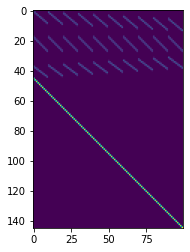

In [14]:
# verify construct_M
X_small = construct_X(M=10, alphas=np.array([-33, 1, 42]), Np=15, tau=10)
plt.imshow(X_small.todense())
plt.show()

In [15]:
def reconstruct_image(X, y, tolerance):
    X = scipy.sparse.csc_matrix(X)
    beta, solution, *_ = scipy.sparse.linalg.lsqr(X, y, atol=tolerance, btol=tolerance)
    
    #if solution != 1:
    #    print("system could only be solved by minimizing squared errors")

    return beta

In [16]:
def test_regularization(y, tolerance, M, alphas, Np, tau, alphasize):
    alphas = alphas[:alphasize]
    y = y[0:Np*alphasize]
    X = construct_X(M, alphas, Np, tau)
    if(tau):
        y = np.append(y, np.zeros(M*M))
    beta = reconstruct_image(X, y, tolerance)
    img = beta.reshape((M, M))

    return img

Note, that the image looks distorted because the size of alpha was limited to 64 angles, as required by the exercise. 

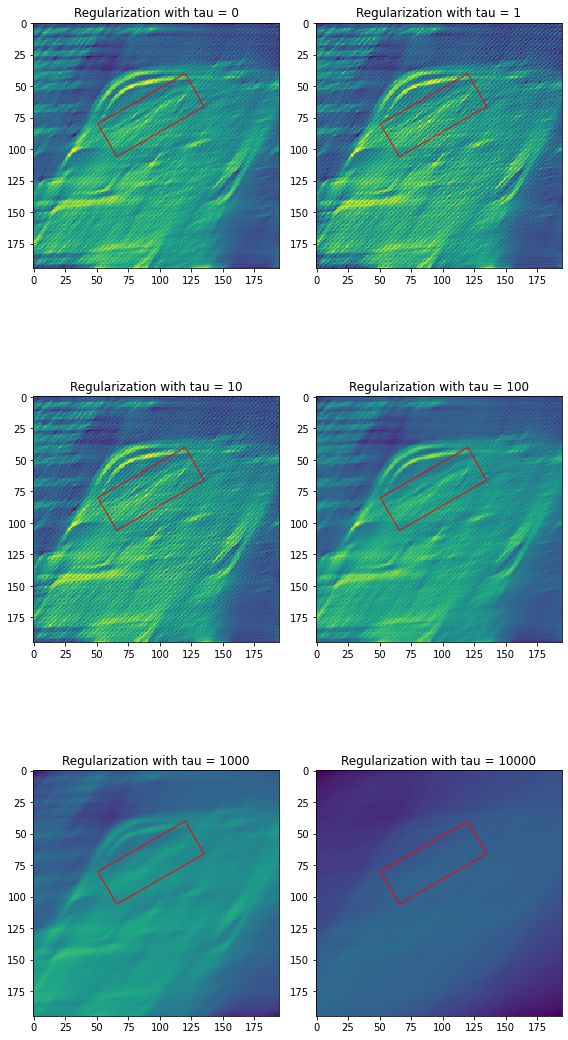

In [17]:
fig, axes = plt.subplots(3, 2, figsize = (8,16))

taus = [0, 1, 10, 100, 1000, 10_000]
for i, tau in enumerate(taus):
    img = test_regularization(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, tau=tau, alphasize=64)
    axes.flat[i].imshow(img, vmin = 0, vmax = 255, interpolation = 'nearest')
    axes.flat[i].set_title(f"Regularization with tau = {tau}")
    axes.flat[i].add_patch(patches.Rectangle((120, 40), 30, 80, angle=60, linewidth=1, edgecolor='r', facecolor='none'))

fig.tight_layout()
plt.show()

In [18]:
def test_gaussian_filter(y, tolerance, M, alphas, Np, sigma, alphasize):
    alphas = alphas[:alphasize]
    y = y[0:Np*alphasize]
    X = construct_X(M, alphas, Np)

    beta = reconstruct_image(X, y, tolerance)
    img = beta.reshape((M, M))

    img = gaussian_filter(img, sigma)
    return img

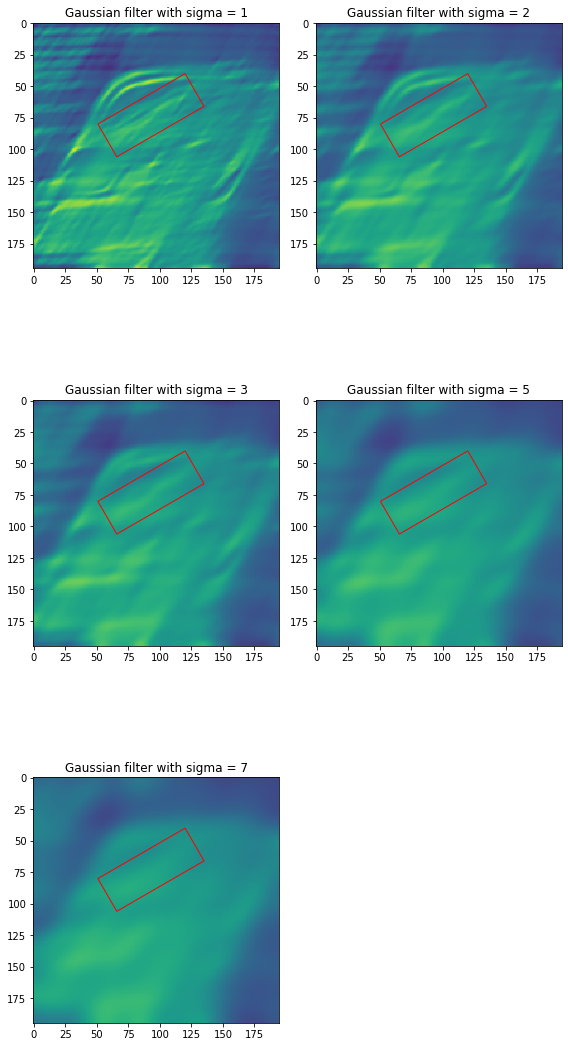

In [19]:
fig, axes = plt.subplots(3, 2, figsize = (8,16))

sigmas = [1, 2, 3, 5, 7]

for i, sigma in enumerate(sigmas):
    img = test_gaussian_filter(y=y_195, tolerance=3e-3, M=195, alphas=alphas_195, Np=275, sigma=sigma, alphasize=64)

    axes.flat[i].imshow(img, vmin = 0, vmax = 255, interpolation = 'nearest')
    axes.flat[i].set_title(f"Gaussian filter with sigma = {sigma}")
    axes.flat[i].add_patch(patches.Rectangle((120, 40), 30, 80, angle=60, linewidth=1, edgecolor='r', facecolor='none'))

fig.delaxes(axes.flat[-1])
fig.tight_layout()
plt.show()

# 3

In [20]:
from scipy.linalg import lstsq
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_digits
from sklearn import model_selection
import seaborn as sn

# 3.1

In [21]:
def omp_regression(X, y, T):
    D = X.shape[1]
    N = X.shape[0]
    X_inactive = X
    X_active = np.array([])
    j_current = None
    r_current = y
    A = np.array([], dtype=int)
    B = np.mgrid[0:D]
    solution = np.zeros((T, D))
    for t in range(T):
        j_current = np.argmax(np.abs(X_inactive.T.dot(r_current)))
        A = np.append(A, B[j_current])
        A = np.sort(A)
        B = np.delete(B, j_current)

        X_active = X[:,A]
        X_inactive = X[:,B]
        beta, r, *_ = lstsq(X_active, y)
        r_current = y - X_active.dot(beta)
        np.put(solution[t], A, beta)
    return solution

# 3.2

In [22]:
digits = load_digits()
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [23]:
one_label = target[target == 1] * 1
seven_label = target[target == 7] / -7

one_data = data[target == 1]
seven_data = data[target == 7]

X_all = np.vstack((one_data, seven_data))
y_all = np.hstack((one_label, seven_label))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_all, y_all, test_size = 0.4, random_state = 0)

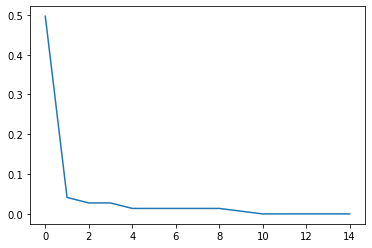

In [24]:
T = 15
beta = omp_regression(X_train, y_train, T)
err = []

for t in range(T):
    y_predicted = X_test.dot(beta[t])
    y_predicted[y_predicted < 0] = -1
    y_predicted[y_predicted > 0] = 1
    err.append(np.mean(y_predicted != y_test))

plt.plot(range(T), err)
plt.show()

The error stays about the same for more than 10 pixels. Therefore between 2 and 10 pixels should be selected.

In [25]:
selection_order = np.transpose(np.nonzero(beta))[:,1]
_, index = np.unique(selection_order, return_index=True)
unique_order = selection_order[np.sort(index)]

In [26]:
vote = beta[T-1][unique_order]

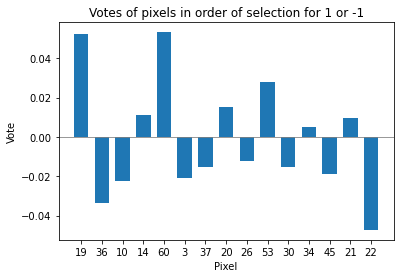

In [27]:
N = T
ind = np.arange(N)    # the x locations for the groups

fig, ax = plt.subplots()
p1 = ax.bar(ind, vote, width=0.7)
ax.axhline(0, color='grey', linewidth=0.8)
ax.set_xticks(ind, labels=map(str, unique_order))
ax.set_ylabel('Vote')
ax.set_xlabel('Pixel')
ax.set_title('Votes of pixels in order of selection for 1 or -1')
plt.show()

# 3.3

In [28]:
T = 1

In [29]:
def random_index(N):
    return np.random.permutation(np.arange(N))

In [30]:
# filter out training set so that for each class there are T elements
def create_training_and_test_sets(T):
    training_indices = np.array([np.arange(len(target))[target == c][random_index(T)]
                                    for c in np.unique(target)]).flatten()

    X_train = data[training_indices]
    y_train = target[training_indices]
    X_test = np.delete(data, training_indices, axis=0)
    y_test = np.delete(target, training_indices, axis=0)
    
    return X_train, y_train, X_test, y_test

In [31]:
def random_elements(arr, N):
    return arr[random_index(N)]
    
def aux_training_set(X, y, k, T):
    X_pos = X[y == k]
    X_pos = random_elements(X_pos, T)
    
    X_neg = X[y != k]
    X_neg = random_elements(X_neg, T)
    
    y = np.concatenate([np.ones(T), -np.ones(T)])
    X = np.concatenate([X_pos, X_neg])
    
    shuffle = random_index(2 * T)

    return X[shuffle], y[shuffle]

In [32]:
def train_one_vs_rest(X_train, y_train, T):
    C_k = [aux_training_set(X_train, y_train, num, T) for num in np.unique(y_train)]
    ldas = np.array([omp_regression(X_k, y_k, 30) for X_k, y_k in C_k])
    
    return ldas

In [33]:
def predict_one_vs_rest(X_test, ldas):
    votes = X_test.dot(ldas.transpose((0, 2, 1)))
    votes[votes < 0] = -1
    votes[votes >= 0] = 1

    votes = votes.sum(axis=2)

    # count votes and select prediction with most
    pred = votes.argmax(axis=1)

    # unkown category
    pred[np.all(votes < 0, axis=1)] = -1
    
    return pred

In [34]:
X_train, y_train, X_test, y_test = create_training_and_test_sets(T)
ldas = train_one_vs_rest(X_train, y_train, T)

In [35]:
pred = predict_one_vs_rest(X_test, ldas)

In [36]:
sum(y_test != pred) / len(pred)

0.6105204252937885

In [37]:
def confusion_matrix(pred, y_test):
    confusion = np.zeros((10, 11))

    for i, real_label in enumerate(range(10)):
        ind = y_test == real_label

        for j, predicted_label in enumerate(list(range(10)) + [-1]):
            confusion[i, j] = 100 * sum(pred[ind] == predicted_label) / len(pred)
            
    return confusion

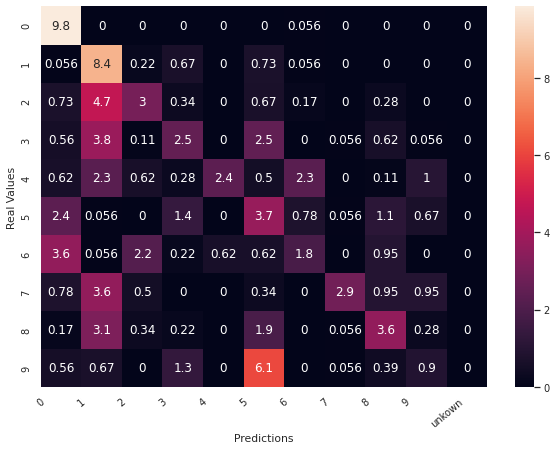

In [38]:
confusion = confusion_matrix(pred, y_test)
plt.figure(figsize=(10,7))

sn.set(font_scale=0.9) # for label size
sn.heatmap(confusion, annot=True, annot_kws={"size": 12}) # font size
plt.xlabel("Predictions")
plt.xticks(range(11), list(range(10)) + ["unkown"], rotation=40)
plt.ylabel("Real Values")
plt.show()

In [39]:
np.any(pred == -1)

False